<a href="https://colab.research.google.com/github/bb426/image_segmentation/blob/main/U_Net_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  28.0M      0  0:00:26  0:00:26 --:--:-- 29.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  9808k      0  0:00:01  0:00:01 --:--:-- 9802k


In [5]:
!ls annotations

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [10]:
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

In [7]:
input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [18]:
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png') and not fname.startswith('.')])

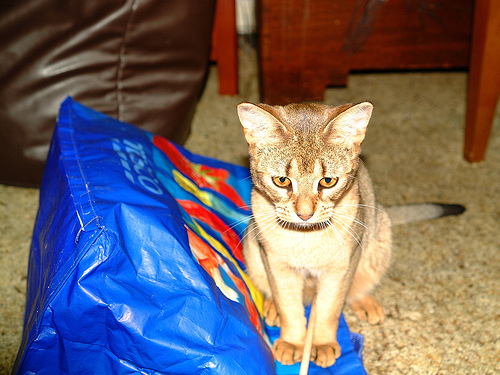

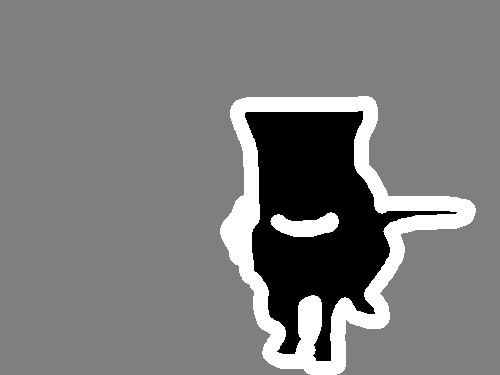

In [19]:
display(Image(filename=input_img_paths[7]))

img = PIL.ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)

## Preprocessing

In [26]:
import numpy as np
from tensorflow import keras

In [21]:
class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i:i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i:i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3, ), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        
        y = np.zeros((self.batch_size,) + self.img_size + (1, ), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1

        return x, y

In [22]:
import random
random_seed = 0

val_samples = 1_000
random.Random(random_seed).shuffle(input_img_paths)
random.Random(random_seed).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [23]:
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Define a model

In [25]:
from tensorflow.keras import layers

In [29]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    for filter in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    model = keras.Model(inputs, outputs)
    return model

In [31]:
model = get_model(img_size, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 80, 80, 32)   896         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 80, 80, 32)  128         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                            

## Training

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)]
epochs = 20


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
199/199 [==============================] - ETA: 0s - loss: 1.4804

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


199/199 [==============================] - 386s 2s/step - loss: 1.4804 - val_loss: 1.9331
Epoch 2/20
199/199 [==============================] - 364s 2s/step - loss: 0.6452 - val_loss: 1.7059
Epoch 3/20
199/199 [==============================] - 364s 2s/step - loss: 0.5199 - val_loss: 0.5383
Epoch 4/20
199/199 [==============================] - 364s 2s/step - loss: 0.4464 - val_loss: 0.5188
Epoch 5/20
199/199 [==============================] - 364s 2s/step - loss: 0.4055 - val_loss: 0.3999
Epoch 6/20
199/199 [==============================] - 364s 2s/step - loss: 0.3651 - val_loss: 0.4116
Epoch 7/20
199/199 [==============================] - 365s 2s/step - loss: 0.3400 - val_loss: 0.4282
Epoch 8/20
199/199 [==============================] - 364s 2s/step - loss: 0.3136 - val_loss: 0.4410
Epoch 9/20
199/199 [==============================] - 364s 2s/step - loss: 0.2892 - val_loss: 0.3780
Epoch 10/20
199/199 [==============================] - 363s 2s/step - loss: 0.2712 - val_loss: 0.4464


## Infer an individual image

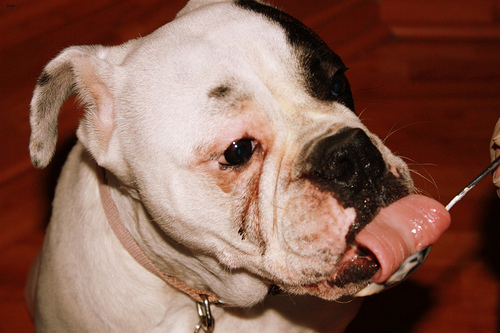

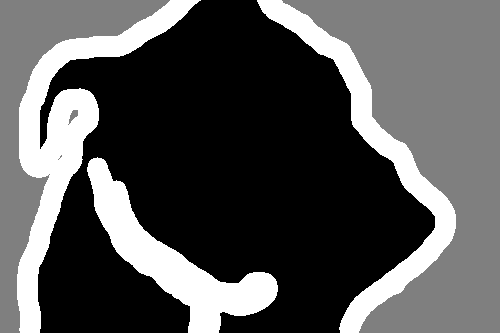

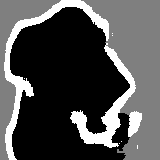

In [36]:
val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

i = 20
display(Image(filename=val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)